In [3]:
import re
import numpy as np
import altair as alt
from collections import Counter

alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

# SongShu -- Place Names Export (Part 1)

In this tutorial, I would use `regex` to export place names in SongShu to `csv` files. And, hopefully, I would try to export the natural place names in SongShu. Some Data Vizs would be experimentally put in this notebook. 

Tasks:
- <span class="mark">**Part 1**: place names regex</span>
- **Part 2**: export place names (from `"劉宋地名與官名 2017-11-14.xlsx"`) and the frequency of characters attached on these place names
- **Part 3**: export natural place names (using "洲", "山")

## Place Name Regex

### Import DataFrame

Before starting to design the regex pattern, let's take a look at the table `劉宋地名與官名 2017-11-14.xlsx`.

In [1]:
# I would use pandas to deal with table data
import pandas as pd

place_excel = pd.ExcelFile("劉宋地名與官名 2017-11-14.xlsx")
df_place    = pd.read_excel(place_excel, "Places") # reading the "Places" sheet
df_place.head()

ID Name   郡名  州名
0  lsp0002   建康  丹陽尹  揚州
1  lsp0003   秣陵  丹陽尹  揚州
2  lsp0004   丹楊  丹陽尹  揚州
3  lsp0005   江寧  丹陽尹  揚州
4  lsp0006   永世  丹陽尹  揚州

We don't want "郡" in the `Name` column, so preprocess the `Name` column to exclude "郡".

In [4]:
df_place.Name = [re.sub(r"(.+)?郡", r"\1", name) for name in df_place.Name]

Also, check if there are the duplicate `Name`s.

In [5]:
# there are some duplicate Names in the DataFrame
Counter(df_place.Name).most_common(5)

[('頓丘', 6), ('晉興', 6), ('新城', 5), ('建安', 5), ('始平', 5)]

In [6]:
df_place[df_place.Name == "頓丘"] # Oops... there are duplicate Names ...

ID Name   郡名   州名
167   lsp0172   頓丘  濟陰郡   徐州
190   lsp0196   頓丘   秦郡  南兗州
227   lsp0234   頓丘  陽平郡   兗州
497   lsp0509   頓丘   魏郡   冀州
505   lsp0517   頓丘  頓丘郡   冀州
1380  lsp3109   頓丘  NaN   冀州

Apparently, one place name would refer to duplicate 郡 and 州 😅
Well, so, that means it is wrong if I referring to an `ID` only based on the knowledge of `Name`... 

I guess the `ID` would only be labeled in the second stages... only after we have the knowledge about 郡 & 州, we have the the actual `ID`. So, let me forget the `ID` by now.

### Get Text: SongShu Class

If you haven't fetch the SonShu data from Han-Ji, you can run the following lines to fetch data.

In [ ]:
from SongShu import SongShu
songshu = SongShu("2018-06-28", "MF")
songshu.fetch_data(URL="(The first page URL of SongShu in Han-Ji)", 
                   pages_limit=2000, print_bookmark=True)
songshu.write_htmls()

If you already have the data, run the following lines to load the htmls.

In [14]:
from SongShu import SongShu
songshu = SongShu("2018-08-25", "MF")
songshu.load_htmls()

INFO:root:Stop at loading data/SongShu_0851.html.
INFO:root:Total length of the data is 851.


In [15]:
# preprocessing the songshu data to get metadata and bookmarks
# and separate the passages in every pages
songshu.extract_all()

ERROR:root:[Error] SongShu_rare_char.json does not exist

            try to run these lines: 
            	>> self.extract_rare_chars()
            	>> self.write_rare_chars()



The <font color="#A60628">Warning</font> in the above output cell show that some pages in SonShu do not have a clear definition of **separating the passages**.

In [16]:
# preview some entries
songshu.paths[::200]

['史／正史／宋書／本紀\u3000凡十卷／卷一\u3000本紀第一／武帝\u3000劉裕\u3000上(P.1)..[底本：宋元明三朝遞修本]',
 '史／正史／宋書／志\u3000凡三十卷／卷二十一\u3000志第十一／樂三／相和／厥初生\u3000精列\u3000武帝詞(P.604)..[底本：宋元明三朝遞修本]',
 '史／正史／宋書／志\u3000凡三十卷／卷二十九\u3000志第十九／符瑞下／白兔(P.837)..[底本：宋元明三朝遞修本]',
 '史／正史／宋書／列傳\u3000凡六十卷／卷四十三\u3000列傳第三／檀道濟\u3000薛彤\u3000高進之(P.1341)..[底本：宋元明三朝遞修本]',
 '史／正史／宋書／列傳\u3000凡六十卷／卷九十三\u3000列傳第五十三／隱逸／翟法賜(P.2286)..[底本：宋元明三朝遞修本]']

In [17]:
# preview some entries
songshu.flat_meta[::200]

[{'category': '本紀',
  'category_number': '本紀第一',
  'scroll': '卷一',
  'title': '武帝\u3000劉裕\u3000上(P.1)'},
 {'category': '志',
  'category_number': '志第十一',
  'scroll': '卷二十一',
  'title': '樂三/相和/厥初生\u3000精列\u3000武帝詞(P.604)'},
 {'category': '志',
  'category_number': '志第十九',
  'scroll': '卷二十九',
  'title': '符瑞下/白兔(P.837)'},
 {'category': '列傳',
  'category_number': '列傳第三',
  'scroll': '卷四十三',
  'title': '檀道濟\u3000薛彤\u3000高進之(P.1341)'},
 {'category': '列傳',
  'category_number': '列傳第五十三',
  'scroll': '卷九十三',
  'title': '隱逸/翟法賜(P.2286)'}]

In [18]:
# preview some entries
[passages[::10] for passages in songshu.flat_passages[::200]]

[['高祖武皇帝諱裕，字德輿，小名寄奴，彭城縣綏輿里人，漢高帝弟楚元王交之後也。交生紅懿侯富，富生宗正辟彊，辟彊生陽城繆侯德，德生陽城節侯安民，安民生陽城釐侯慶忌，慶忌生陽城肅侯岑，岑生宗正平，平生東武城令某，某生東萊太守景，景生明經洽，洽生博士弘，弘生瑯邪都尉悝，悝生魏定襄太守某，某生邪城令亮，亮生晉北平太守膺，膺生相國掾熙，熙生開封令旭孫。旭孫生混，始過江，居晉陵郡丹徒縣之京口里，官至武原令。混生東安太守靖，靖生郡功曹翹，是為皇考。高祖以晉哀帝興寧元年歲次癸亥三月壬寅夜生。及長，身長七尺六寸，風骨奇特。家貧，有大志，不治廉隅。事繼母以孝謹稱。',
  '義軍初剋京城，脩司馬刁弘率文武佐吏來赴。高祖登城謂之曰：「郭江州已奉乘輿反正於尋陽，我等並被密詔，誅除逆黨，同會今日。賊玄之首，已當梟於大航矣。諸君非大晉之臣乎，今來欲何為？」弘等信之，收眾而退。毅既至，高祖命誅弘。',
  '尚書左僕射王愉、愉子荊州刺史綏等，江左冠族。綏少有重名，以高祖起自布衣，甚相凌忽。綏，桓氏甥，亦有自疑之志。高祖悉誅之。',
  '十一月，天子重申前令，加高祖侍中，進號車騎將軍、開府儀同三司。固讓。詔遣百僚敦勸。',
  '明日，大軍進廣固，即屠大城，超退保小城。於是設長圍守之，圍高三丈，外穿三重塹。停江、淮轉輸，館穀於齊土。撫納降附，華戎歡悅，援才授爵，因而任之。七月，詔加公北青、冀二州刺史。超大將垣遵、遵弟苗並率眾歸順。公方治攻具，城上人曰：「汝不得張綱，何能為也。」綱者，超偽尚書郎，其人有巧思。會超遣綱稱藩於姚興，乞師請救。興偽許之，而實憚公，不敢遣。綱從長安還，泰山太守申宣執送之。及升綱於樓車，以示城內，城內莫不失色。於是使綱大治攻具。超求救不獲，綱反見虜，轉憂懼。乃請稱藩，求割大峴為界，獻馬千疋。不聽，圍之轉急。河北居民荷戈負糧至者，日以千數。',
  '於是大開賞募，投身赴義者，一同登京城之科。發居民治石頭城，建牙戒嚴。時議者謂宜分兵守諸津要。公以為：「賊眾我寡，若分兵屯，則人測虛實。且一處失利，則沮三軍之心。今聚眾石頭，隨宜應赴，既令賊無以測多少，又於眾力不分。若徒旅轉集，徐更論之耳。」移屯石頭，乃柵淮斷查浦。既而羣賊大至，公策之曰：「賊若於新亭直進，其鋒不可當，宜且回避，勝負之事，未可量也。若回泊西岸，此成擒耳。」'],
 ['厥初生，造化之陶物，莫不有終期。莫不有終期，

#### Data Viz: Simple barchart

The idea is that to plot each page to a bar.

本紀

In [19]:
# only consider 本紀
for i,path in enumerate(songshu.paths):
    if "本紀" not in path:
        idx_ben_ji = i
        break
idx_ben_ji        

73

In [20]:
# a silly way to append values
x = []; y = []; z = []; category = []; scroll = []; title = []; text = [];
for i,(passages, meta) in enumerate( zip(songshu.flat_passages[:idx_ben_ji], 
                           songshu.flat_meta[:idx_ben_ji]) ):
    for j,p in enumerate(passages):
        x.append(i)
        y.append(j)
        z.append(len(p))
        category.append(meta['category'])
        scroll.append(meta['scroll'])
        title.append(meta['title'])
        text.append(p)

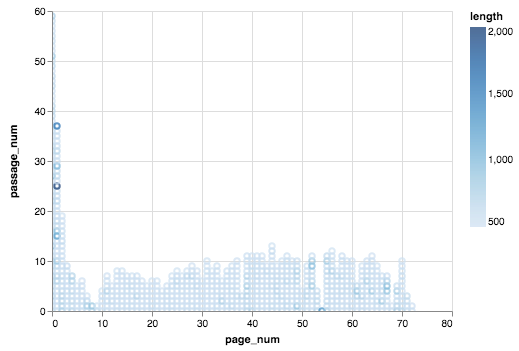

In [21]:
# Convert the data to pandas to allow Altair to read
data = pd.DataFrame({'page_num': x,
                     'passage_num': y,
                     'length': z, 
                     'category' : category, 
                     'scroll' : scroll, 
                     'title' : title, 
                     'text' : text
                     })

alt.Chart(data).mark_point().encode(
    x='page_num',
    y='passage_num',
    color='length',
    tooltip=['category', 'scroll', 'title', 'text']
).interactive()

How about 列傳?

In [22]:
# only consider 列傳
for i,path in enumerate(songshu.paths):
    if "列傳" in path:
        idx_lei_chuan = i # remenber the order is 本紀 -> 志 -> 列傳
        break

# a silly way to append values
x = []; y = []; z = []; category = []; scroll = []; title = []; text = [];
for i,(passages, meta) in enumerate( zip(songshu.flat_passages[idx_lei_chuan:], 
                           songshu.flat_meta[idx_lei_chuan:]) ):
    for j,p in enumerate(passages):
        x.append(i)
        y.append(j)
        z.append(len(p))
        category.append(meta['category'])
        scroll.append(meta['scroll'])
        title.append(meta['title'])
        text.append(p)        

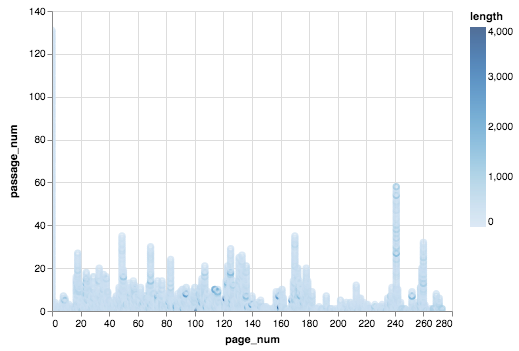

In [23]:
# Convert the data to pandas to allow Altair to read
data = pd.DataFrame({'page_num': x,
                     'passage_num': y,
                     'length': z, 
                     'category' : category, 
                     'scroll' : scroll, 
                     'title' : title, 
                     'text' : text
                     })

alt.Chart(data).mark_point().encode(
    x='page_num',
    y='passage_num',
    color='length',
    tooltip=['category', 'scroll', 'title', 'text']
).interactive()

### Match Place Names in Every Passages

Now, we can try to match all place names in SongShu using `劉宋地名與官名 2017-11-14.xlsx`.

In [24]:
# quick review of `df_place` pandas.DataFrame
df_place.head()

ID Name   郡名  州名
0  lsp0002   建康  丹陽尹  揚州
1  lsp0003   秣陵  丹陽尹  揚州
2  lsp0004   丹楊  丹陽尹  揚州
3  lsp0005   江寧  丹陽尹  揚州
4  lsp0006   永世  丹陽尹  揚州

In [25]:
# get an unique set of Names
place_name_set = set(df_place.Name)

In [29]:
# find the match place names
regex = r"([^、。，？！：；「」〔〕『』]*?)({})([^、。，？！：；「」〔〕『』]*)".format(r"|".join(place_name_set))

flat_place_names = []
# a horrible triple loop (lol)
for passages in songshu.flat_passages:
    place_names = []
    for p in passages:
        place_names.append([(
            match.group(1), match.group(2), match.group(3)) 
            for match in re.finditer(regex, p)
        ])
        
    flat_place_names.append(place_names)
    
        
# it takes some times ... since it is a horrible python for loop 😭

In [30]:
# preview the list
flat_place_names[0][:2]

# the structure is like
# a sentence: (before the place name, place name, after the place name)

[[('', '彭城', '縣綏輿里人'),
  ('辟彊生', '陽城', '繆侯德'),
  ('德生', '陽城', '節侯安民'),
  ('安民生', '陽城', '釐侯慶忌'),
  ('慶忌生', '陽城', '肅侯岑'),
  ('平生', '東武', '城令某'),
  ('某生', '東萊', '太守景'),
  ('洽生', '博', '士弘'),
  ('悝生', '魏', '定襄太守某'),
  ('膺生', '相', '國掾熙'),
  ('居', '晉陵', '郡丹徒縣之京口里'),
  ('官至', '武原', '令'),
  ('混生', '東安', '太守靖'),
  ('高祖以晉哀帝', '興寧', '元年歲次癸亥三月壬寅夜生')],
 [('初為', '冠軍', '孫無終司馬'),
  ('妖賊孫恩作亂於', '會稽', ''),
  ('牢之至', '吳', ''),
  ('', '平山', '陰')]]

#### Export `(before the place name, place name, after the place name)` Tuples

I guess someone would like to play with this data, so I keep it in a `csv` form.

In [31]:
df_sentence_tuples = pd.DataFrame(
    [tup for place_names in flat_place_names for place_name in place_names for tup in place_name],
    columns=['before_tag', 'tag', 'after_tag']
)
with open("SongShu_placeTags_sentences.csv", "w", encoding="utf-8") as file:
    file.write('# regex = r"([^、。，？！：；「」〔〕『』]+)?({})([^、。，？！：；「」〔〕『』]+)?".format(r"|".join(place_name_set))')
    file.write('\n')
    df_sentence_tuples.to_csv(file)
df_sentence_tuples.head()

before_tag tag after_tag
0             彭城     縣綏輿里人
1        辟彊生  陽城       繆侯德
2         德生  陽城      節侯安民
3        安民生  陽城      釐侯慶忌
4        慶忌生  陽城       肅侯岑

*(to be continued...)*